In [1]:
# Instalo dependencias para poder renderizar
!apt-get install x11-utils > /dev/null 2>&1
!pip install pyglet > /dev/null 2>&1
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install "gymnasium[mujoco]" > /dev/null 2>&1
!pip install pyvirtualdisplay > /dev/null 2>&1

In [2]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import random
import time

from gymnasium.wrappers import RecordVideo
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display

# Inicializo el display para renderizar
display = Display(visible=0, size=(400, 300))
display.start()

In [3]:
# --- Inicialización ---
env_name = "InvertedPendulum-v5"

env = RecordVideo(
    gym.make(env_name, render_mode="rgb_array"),
    video_folder="./videos/sarsa",
    episode_trigger=lambda x: (x + 1) % 10000 == 0
)

# Discretización de acciones
num_actions = 21
act_space = np.linspace(-3, 3, num_actions)

# Discretización de estados
num_bins = 10
pos_space = np.linspace(-2.4, 2.4, num_bins)
ang_space = np.linspace(-0.2, 0.2, num_bins)
vel_space = np.linspace(-2, 2, num_bins)
ang_vel_space = np.linspace(-3, 3, num_bins)

def discretize_state(observation):
    pos, ang, vel, ang_vel = observation
    digitized = [
        np.digitize(pos, pos_space),
        np.digitize(ang, ang_space),
        np.digitize(vel, vel_space),
        np.digitize(ang_vel, ang_vel_space)
    ]
    return tuple(digitized)

# SARSA
learning_rate = 0.1        # Alpha: Tasa de aprendizaje
discount_factor = 0.95     # Gamma: Factor de descuento (valor de recompensas futuras)
num_episodes = 20000       # Número de episodios para entrenar

# Exploración (Epsilon-Greedy)
epsilon = 1.0              # Tasa de exploración inicial (100% aleatorio)
max_epsilon = 1.0          # Máximo valor de epsilon
min_epsilon = 0.01         # Mínimo valor de epsilon
epsilon_decay_rate = 0.0005 # Tasa de decaimiento de epsilon por episodio

# Para reporte/gráficas
report_interval = num_episodes // 20 # Cada cuántos episodios mostrar progreso
moving_avg_window = 100    # Ventana para la media móvil en la gráfica

# Inicializar la tabla Q con ceros
q_table = np.zeros((num_bins + 1, num_bins + 1, num_bins + 1, num_bins + 1, num_actions))

# Lista para guardar recompensas y pasos por episodio
rewards_all_episodes = []
steps_all_episodes = []

print(f"--- Iniciando Entrenamiento SARSA ---")
print(f"Entorno: {env_name}")
print(f"Estados: {num_bins * 4}, Acciones: {num_actions}")
print(f"Parámetros: α={learning_rate}, γ={discount_factor}, ε-decay={epsilon_decay_rate}")
print(f"Episodios: {num_episodes}")
print("-" * 40)

start_time = time.time()

# --- Bucle de Entrenamiento ---
for episode in range(num_episodes):
    # Reiniciar entorno
    observation, _ = env.reset()
    state = discretize_state(observation)
    terminated = False
    truncated = False

    total_reward_episode = 0
    steps_episode = 0

    # 1. Primera acción
    if random.uniform(0, 1) < epsilon:
        action_idx = np.random.randint(0, num_actions) # Explorar
    else:
        action_idx = np.argmax(q_table[state]) # Explotar

    while not (terminated or truncated):
        # 2. Ejecutar Acción
        action = act_space[action_idx]
        new_observation, reward, terminated, truncated, _ = env.step([action])
        new_state = discretize_state(new_observation)

        # 3. Próxima acción
        if random.uniform(0, 1) < epsilon:
            new_action_idx = np.random.randint(0, num_actions) # Explorar
        else:
            new_action_idx = np.argmax(q_table[new_state]) # Explotar

        # 4. Actualizar Q-Table (Fórmula de Bellman)
        current_q = q_table[state][action_idx]
        next_q = q_table[new_state][new_action_idx]
        q_table[state][action_idx] = current_q + learning_rate * (reward + discount_factor * next_q - current_q)

        # Actualizar estado, acción y contadores
        state = new_state
        action_idx = new_action_idx
        total_reward_episode += reward
        steps_episode += 1

    # Fin del episodio
    rewards_all_episodes.append(total_reward_episode)
    steps_all_episodes.append(steps_episode)

    # 4. Decaimiento de Epsilon (exponencial)
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-epsilon_decay_rate * episode)

    # Reportar progreso
    if (episode + 1) % report_interval == 0:
        avg_reward = np.mean(rewards_all_episodes[-report_interval:])
        avg_steps = np.mean(steps_all_episodes[-report_interval:])
        print(f"Episodio: {episode+1:>5}/{num_episodes} | "
              f"Recompensa Prom (últimos {report_interval}): {avg_reward:>6.2f} | "
              f"Pasos Prom (últimos {report_interval}): {avg_steps:>6.1f} | "
              f"Epsilon: {epsilon:.3f}")

env.close()
end_time = time.time()

print("-" * 40)
print(f"Entrenamiento finalizado en {end_time - start_time:.2f} segundos.")
print("-" * 40)

--- Iniciando Entrenamiento SARSA ---
Entorno: InvertedPendulum-v5
Estados: 40, Acciones: 21
Parámetros: α=0.1, γ=0.95, ε-decay=0.0005
Episodios: 20000
----------------------------------------
Episodio:  1000/20000 | Recompensa Prom (últimos 1000):   5.78 | Pasos Prom (últimos 1000):    6.8 | Epsilon: 0.611
Episodio:  2000/20000 | Recompensa Prom (últimos 1000):   9.13 | Pasos Prom (últimos 1000):   10.1 | Epsilon: 0.374
Episodio:  3000/20000 | Recompensa Prom (últimos 1000):  13.63 | Pasos Prom (últimos 1000):   14.6 | Epsilon: 0.231
Episodio:  4000/20000 | Recompensa Prom (últimos 1000):  17.78 | Pasos Prom (últimos 1000):   18.8 | Epsilon: 0.144
Episodio:  5000/20000 | Recompensa Prom (últimos 1000):  20.50 | Pasos Prom (últimos 1000):   21.5 | Epsilon: 0.091
Episodio:  6000/20000 | Recompensa Prom (últimos 1000):  25.84 | Pasos Prom (últimos 1000):   26.8 | Epsilon: 0.059
Episodio:  7000/20000 | Recompensa Prom (últimos 1000):  31.90 | Pasos Prom (últimos 1000):   32.9 | Epsilon: 0

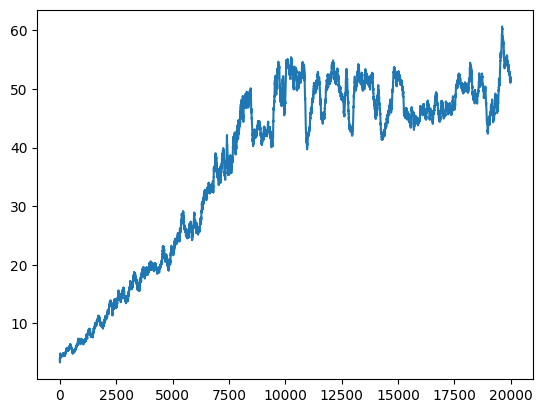

In [4]:
# Gráfica de Convergencia (Recompensas con Media Móvil)
mean_rewards = []
for t in range(num_episodes):
    mean_rewards.append(np.mean(rewards_all_episodes[max(0, t-100):(t+1)]))

plt.plot(mean_rewards)
plt.show()